In [457]:
import itertools
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [458]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
#bert_models = [None, "QQP", "MNLI", "SST", "CoLA", "MRPC", "SNLI", "RTE"]
#bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
checkpoint_steps = list(range(5,255,5))#list(range(50, 5050, 50))#[1000, 2000, 3000, 4000, 5000]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [None, "run1", "run2", "run3"]

In [459]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    
    m_target_runs = [None] if model is None else target_runs
    for target_run in m_target_runs:
        target_run_str = "" if target_run is None else "-%s" % target_run
        
        if model is None:
            model_dir = bert_path / bert_base_model
        else:
            # DEV
            model_dir = bert_path / ("%s.%s.%s%s" % (finetune_desc, bert_base_model, model, target_run_str))

        try:
            model_metadata[model, target_run] = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        except: pass
            
        print("\t", target_run)

        # brain decoding results for each checkpoint step
        for checkpoint_step in checkpoint_steps:
            decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
                ("" if model is None else ".%s-%s-%d%s" % (finetune_desc, model, checkpoint_step, target_run_str))
            try:
                decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
            except: continue

            for subj, subj_row in decoding_perf.loc["ridge"].iterrows():
                model_metadata[model, target_run]["steps"][checkpoint_step]["decoding_mean_%s" % subj] = subj_row.mean()
                model_metadata[model, target_run]["steps"][checkpoint_step]["decoding_std_%s" % subj] = subj_row.std()

            model_metadata[model, target_run]["steps"][checkpoint_step].update({
                "decoding_mean": decoding_perf.loc["ridge"].mean().mean(),
                "decoding_std": decoding_perf.loc["ridge"].mean(axis=1).std()
            })

None
Missing training events file in savedir: %s /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
Missing eval events data in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
	 None
SQuAD
	 None
	 run1
	 run2
	 run3
QQP
	 None
	 run1
	 run2
	 run3
MNLI
	 None
	 run1
	 run2
	 run3
SST
	 None
	 run1
	 run2
	 run3


In [460]:
# SQuAD results need to be loaded separately from manual eval.
if "SQuAD" in bert_models:
    for target_run in target_runs:
        target_run_str = "" if target_run is None else "-%s" % target_run
        model_dir = bert_path / ("%s.%s.SQuAD%s" % (finetune_desc, bert_base_model, target_run_str))

        for checkpoint_step in checkpoint_steps:
            pred_dir = model_dir / "predictions" / str(checkpoint_step)
            try:
                with (pred_dir / "results.json").open() as results_f:
                    results = json.load(results_f)
                model_metadata["SQuAD"]["steps"][checkpoint_step]["eval_accuracy"] = results["best_f1"] / 100.
            except: pass

In [461]:
all_subjects = decoding_perf.index.get_level_values(1).unique()
all_subjects

Index(['P01', 'M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15'], dtype='object', name='subject')

In [462]:
# Flatten model results into a single collection.
model_metadata_flat = []

for (model, target_run), metadata in model_metadata.items():
    for step, step_data in metadata["steps"].items():
        for subject in all_subjects:
            model_metadata_flat.append((model if model is not None else "LM",
                                        target_run if target_run is not None else "NA", subject, step,
                                        step_data.get("decoding_mean_%s" % subject, np.nan), step_data.get("decoding_std_%s" % subject, np.nan),
                                        metadata.get("first_train_loss", None), metadata.get("first_train_loss_norm", None),
                                        step_data.get("train_loss", None), step_data.get("train_loss_norm", None),
                                        step_data.get("total_global_norms", None),
                                        step_data.get("eval_loss"), step_data.get("eval_accuracy")))
        
df = pd.DataFrame(model_metadata_flat, columns=("model", "run", "subject", "step", "decoding_mean", "decoding_std",
                                                "first_train_loss", "first_train_loss_norm", "train_loss", "train_loss_norm",
                                                "total_global_norms",
                                                "eval_loss", "eval_accuracy")).sort_values(["model", "subject", "step"])

In [463]:
df.tail()

model   run subject  step  decoding_mean  decoding_std  first_train_loss  \
5184   SST  run2     P01   245      69.693122     16.144086          0.775721   
5584   SST  run3     P01   245      77.521164     21.610411          0.716799   
4792   SST  run1     P01   250      78.171958     19.331106          0.717911   
5192   SST  run2     P01   250      69.788360     16.141863          0.775721   
5592   SST  run3     P01   250      77.523810     21.622916          0.716799   

      first_train_loss_norm  train_loss  train_loss_norm  total_global_norms  \
5184               0.387860    0.165216         0.082608          346.012938   
5584               0.358399    0.116496         0.058248          357.156017   
4792               0.358956    0.127800         0.063900           11.920548   
5192               0.387860    0.217266         0.108633          350.472056   
5592               0.358399    0.154268         0.077134          365.019650   

      eval_loss  eval_accuracy  
5184   0.237684       0.908750  
5584   0.243315       0.905000  
4792   0.226637       0.917431  
5192   0.242401       0.905963  
5592   0.248986       0.904817

In [464]:
df["train_loss_delta"] = df["train_loss"] - df["first_train_loss"]
df["train_loss_norm_delta"] = df["train_loss_norm"] - df["first_train_loss_norm"]

df["eval_accuracy_norm"] = df.groupby(["model", "run"]).eval_accuracy.fillna(0.0).transform(lambda accs: (accs - accs.min()) / (accs.max() - accs.min()))

df["decoding_mean_delta"] = df.groupby(["model", "run", "subject"]).decoding_mean.transform(lambda xs: xs - xs.iloc[0])
df.head()

model run subject  step  decoding_mean  decoding_std  first_train_loss  \
1     LM  NA     M02     5      61.005291     14.564277               NaN   
9     LM  NA     M02    10      61.005291     14.564277               NaN   
17    LM  NA     M02    15      61.005291     14.564277               NaN   
25    LM  NA     M02    20      61.005291     14.564277               NaN   
33    LM  NA     M02    25      61.005291     14.564277               NaN   

    first_train_loss_norm  train_loss  train_loss_norm  total_global_norms  \
1                     NaN         NaN              NaN                 NaN   
9                     NaN         NaN              NaN                 NaN   
17                    NaN         NaN              NaN                 NaN   
25                    NaN         NaN              NaN                 NaN   
33                    NaN         NaN              NaN                 NaN   

    eval_loss  eval_accuracy  train_loss_delta  train_loss_norm_delta  \
1         NaN            NaN               NaN                    NaN   
9         NaN            NaN               NaN                    NaN   
17        NaN            NaN               NaN                    NaN   
25        NaN            NaN               NaN                    NaN   
33        NaN            NaN               NaN                    NaN   

    eval_accuracy_norm  decoding_mean_delta  
1                  0.0                  0.0  
9                  0.0                  0.0  
17                 0.0                  0.0  
25                 0.0                  0.0  
33                 0.0                  0.0

In [465]:
ROLLING_WINDOW_SIZE = 5
grouped = df.groupby(["model", "run", "subject"])
for col in ["decoding_mean", "decoding_mean_delta", "eval_accuracy", "train_loss"]:
    df["%s_rolling" % col] = grouped[col].transform(lambda rows: rows.rolling(ROLLING_WINDOW_SIZE).mean())

In [466]:
df.tail()

model   run subject  step  decoding_mean  decoding_std  first_train_loss  \
5184   SST  run2     P01   245      69.693122     16.144086          0.775721   
5584   SST  run3     P01   245      77.521164     21.610411          0.716799   
4792   SST  run1     P01   250      78.171958     19.331106          0.717911   
5192   SST  run2     P01   250      69.788360     16.141863          0.775721   
5592   SST  run3     P01   250      77.523810     21.622916          0.716799   

      first_train_loss_norm  train_loss  train_loss_norm         ...          \
5184               0.387860    0.165216         0.082608         ...           
5584               0.358399    0.116496         0.058248         ...           
4792               0.358956    0.127800         0.063900         ...           
5192               0.387860    0.217266         0.108633         ...           
5592               0.358399    0.154268         0.077134         ...           

      eval_loss  eval_accuracy  train_loss_delta  train_loss_norm_delta  \
5184   0.237684       0.908750         -0.610505              -0.305252   
5584   0.243315       0.905000         -0.600302              -0.300151   
4792   0.226637       0.917431         -0.590111              -0.295056   
5192   0.242401       0.905963         -0.558455              -0.279227   
5592   0.248986       0.904817         -0.562531              -0.281265   

      eval_accuracy_norm  decoding_mean_delta  decoding_mean_rolling  \
5184            0.986431            21.111111              69.013228   
5584            0.982361            28.791005              77.478836   
4792            0.995855            29.735450              77.915344   
5192            0.983407            21.206349              69.253439   
5592            0.982162            28.793651              77.474603   

      decoding_mean_delta_rolling  eval_accuracy_rolling  train_loss_rolling  
5184                    20.431217               0.910000            0.236204  
5584                    28.748677               0.900000            0.217379  
4792                    29.478836               0.918736            0.127800  
5192                    20.671429               0.909193            0.230665  
5592                    28.744444               0.902213            0.227378  

[5 rows x 21 columns]

## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

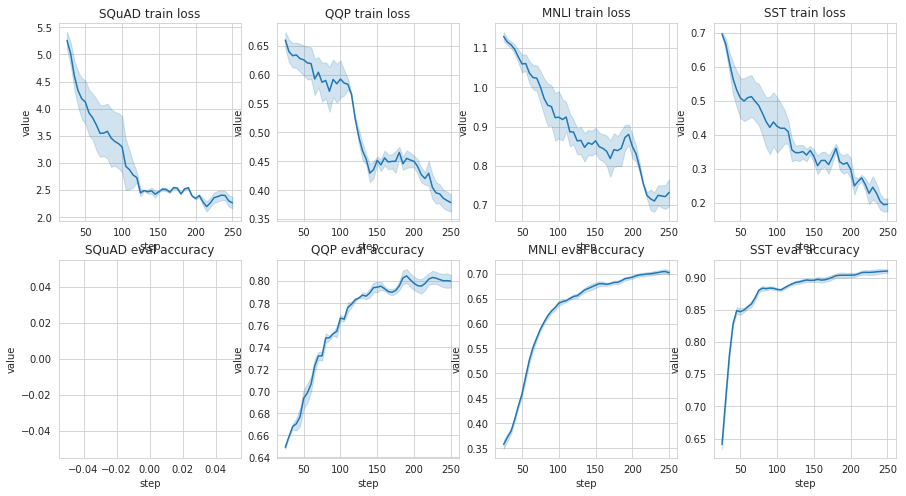

In [467]:
models = [m for m in bert_models if m is not None]
f, axs = plt.subplots(2, len(models), figsize=(15, 8))

for model, ax in zip(models, axs[0]):
    model_data = pd.melt(df[df.model == model], id_vars=["run", "step"], value_vars=["train_loss_rolling"])
    sns.lineplot(data=model_data, x="step", y="value", ax=ax)
    ax.set_title("%s train loss" % model)
    
for model, ax in zip(models, axs[1]):
    model_data = pd.melt(df[df.model == model], id_vars=["run", "step"], value_vars=["eval_accuracy_rolling"])
    sns.lineplot(data=model_data, x="step", y="value", ax=ax)
    ax.set_title("%s eval accuracy" % model)

MRPC and RTE are definitely overfitting — let's exclude some of the later training steps.

In [468]:
df = df.drop(index=df[(df.model == "MRPC") & (df.step > 750)].index)
df = df.drop(index=df[(df.model == "RTE") & (df.step > 1000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  5600.000000    5200.000000   5200.000000       5200.000000   
mean    127.500000     111.557713     24.386394          2.438122   
std      72.160792      30.425388      6.397845          2.373002   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      87.754630     20.060610          0.716799   
50%     127.500000     115.730159     23.500032          1.065172   
75%     190.000000     137.237434     29.081165          5.962796   
max     250.000000     167.957672     39.899241          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            3600.000000  5200.000000      3600.000000   
mean                0.366262     1.356733         0.248788   
std                 0.024129     1.370123         0.086458   
min                 0.335767     0.104277         0.052139   
25%                 0.352233     0.451657         0.198695   
50%                 0.358399     0.723610         0.242486   
75%                 0.378735     2.189941         0.322125   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  train_loss_delta  \
count         5200.000000  3600.000000    3600.000000       5200.000000   
mean           155.792767     0.537052       0.747596         -1.081389   
std            186.370900     0.246670       0.136331          1.431670   
min              2.407880     0.222312       0.282500         -4.597517   
25%             11.959012     0.313051       0.672500         -2.200309   
50%             90.232063     0.447398       0.778125         -0.340902   
75%            229.839229     0.741349       0.875000         -0.164903   
max            807.520106     1.191974       0.921250          0.075408   

       train_loss_norm_delta  eval_accuracy_norm  decoding_mean_delta  \
count            3600.000000         5600.000000          5200.000000   
mean               -0.117474            0.521680            15.268870   
std                 0.087679            0.406569            14.116178   
min                -0.327921            0.000000            -6.489418   
25%                -0.173188            0.000000             0.925926   
50%                -0.113481            0.721845            12.968254   
75%                -0.050611            0.867368            28.558201   
max                 0.037704            1.000000            63.391534   

       decoding_mean_rolling  decoding_mean_delta_rolling  \
count            4784.000000                  4784.000000   
mean              112.073719                    15.784875   
std                30.035457                    13.674020   
min                44.749735                    -5.875661   
25%                89.310053                     2.609921   
50%               116.041270                    13.768519   
75%               137.890079                    28.623016   
max               163.802646                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            3312.000000         4784.000000  
mean                0.755520            1.329887  
std                 0.125166            1.286301  
min                 0.333500            0.127800  
25%                 0.681250            0.442106  
50%                 0.779250            0.759235  
75%                 0.876500            2.346688  
max                 0.919500            6.029931

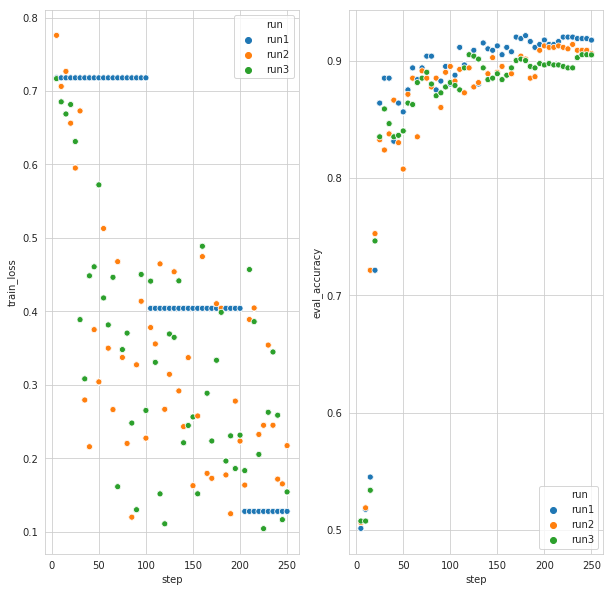

In [469]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "SST"], x="step", y="train_loss", hue="run", ax=axs[0])
sns.scatterplot(data=df[df.model == "SST"], x="step", y="eval_accuracy", hue="run", ax=axs[1])

SST also converges early (around 4000 iters). We'll drop the remaining iterations.

In [470]:
df = df.drop(index=df[(df.model == "SST") & (df.step > 4000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  5600.000000    5200.000000   5200.000000       5200.000000   
mean    127.500000     111.557713     24.386394          2.438122   
std      72.160792      30.425388      6.397845          2.373002   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      87.754630     20.060610          0.716799   
50%     127.500000     115.730159     23.500032          1.065172   
75%     190.000000     137.237434     29.081165          5.962796   
max     250.000000     167.957672     39.899241          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            3600.000000  5200.000000      3600.000000   
mean                0.366262     1.356733         0.248788   
std                 0.024129     1.370123         0.086458   
min                 0.335767     0.104277         0.052139   
25%                 0.352233     0.451657         0.198695   
50%                 0.358399     0.723610         0.242486   
75%                 0.378735     2.189941         0.322125   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  train_loss_delta  \
count         5200.000000  3600.000000    3600.000000       5200.000000   
mean           155.792767     0.537052       0.747596         -1.081389   
std            186.370900     0.246670       0.136331          1.431670   
min              2.407880     0.222312       0.282500         -4.597517   
25%             11.959012     0.313051       0.672500         -2.200309   
50%             90.232063     0.447398       0.778125         -0.340902   
75%            229.839229     0.741349       0.875000         -0.164903   
max            807.520106     1.191974       0.921250          0.075408   

       train_loss_norm_delta  eval_accuracy_norm  decoding_mean_delta  \
count            3600.000000         5600.000000          5200.000000   
mean               -0.117474            0.521680            15.268870   
std                 0.087679            0.406569            14.116178   
min                -0.327921            0.000000            -6.489418   
25%                -0.173188            0.000000             0.925926   
50%                -0.113481            0.721845            12.968254   
75%                -0.050611            0.867368            28.558201   
max                 0.037704            1.000000            63.391534   

       decoding_mean_rolling  decoding_mean_delta_rolling  \
count            4784.000000                  4784.000000   
mean              112.073719                    15.784875   
std                30.035457                    13.674020   
min                44.749735                    -5.875661   
25%                89.310053                     2.609921   
50%               116.041270                    13.768519   
75%               137.890079                    28.623016   
max               163.802646                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            3312.000000         4784.000000  
mean                0.755520            1.329887  
std                 0.125166            1.286301  
min                 0.333500            0.127800  
25%                 0.681250            0.442106  
50%                 0.779250            0.759235  
75%                 0.876500            2.346688  
max                 0.919500            6.029931

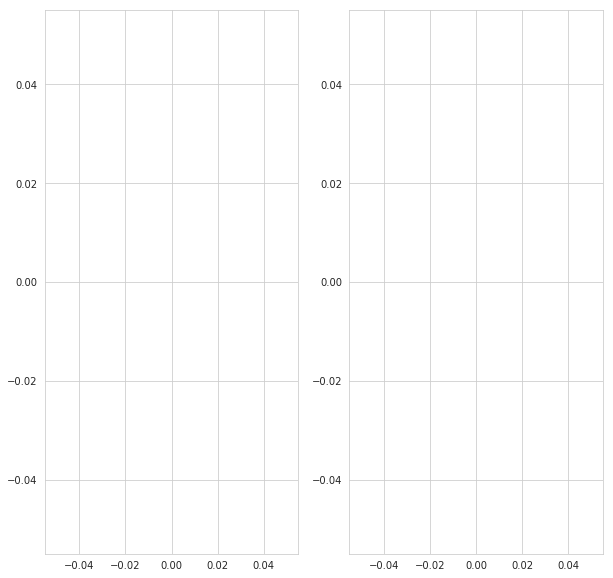

In [471]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="train_loss", ax=axs[0])
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="eval_accuracy", ax=axs[1])

CoLA is also overfitting — we reach near-zero training loss by around iter 2000. Drop.

In [472]:
df = df.drop(index=df[(df.model == "CoLA") & (df.step > 2000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  5600.000000    5200.000000   5200.000000       5200.000000   
mean    127.500000     111.557713     24.386394          2.438122   
std      72.160792      30.425388      6.397845          2.373002   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      87.754630     20.060610          0.716799   
50%     127.500000     115.730159     23.500032          1.065172   
75%     190.000000     137.237434     29.081165          5.962796   
max     250.000000     167.957672     39.899241          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            3600.000000  5200.000000      3600.000000   
mean                0.366262     1.356733         0.248788   
std                 0.024129     1.370123         0.086458   
min                 0.335767     0.104277         0.052139   
25%                 0.352233     0.451657         0.198695   
50%                 0.358399     0.723610         0.242486   
75%                 0.378735     2.189941         0.322125   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  train_loss_delta  \
count         5200.000000  3600.000000    3600.000000       5200.000000   
mean           155.792767     0.537052       0.747596         -1.081389   
std            186.370900     0.246670       0.136331          1.431670   
min              2.407880     0.222312       0.282500         -4.597517   
25%             11.959012     0.313051       0.672500         -2.200309   
50%             90.232063     0.447398       0.778125         -0.340902   
75%            229.839229     0.741349       0.875000         -0.164903   
max            807.520106     1.191974       0.921250          0.075408   

       train_loss_norm_delta  eval_accuracy_norm  decoding_mean_delta  \
count            3600.000000         5600.000000          5200.000000   
mean               -0.117474            0.521680            15.268870   
std                 0.087679            0.406569            14.116178   
min                -0.327921            0.000000            -6.489418   
25%                -0.173188            0.000000             0.925926   
50%                -0.113481            0.721845            12.968254   
75%                -0.050611            0.867368            28.558201   
max                 0.037704            1.000000            63.391534   

       decoding_mean_rolling  decoding_mean_delta_rolling  \
count            4784.000000                  4784.000000   
mean              112.073719                    15.784875   
std                30.035457                    13.674020   
min                44.749735                    -5.875661   
25%                89.310053                     2.609921   
50%               116.041270                    13.768519   
75%               137.890079                    28.623016   
max               163.802646                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            3312.000000         4784.000000  
mean                0.755520            1.329887  
std                 0.125166            1.286301  
min                 0.333500            0.127800  
25%                 0.681250            0.442106  
50%                 0.779250            0.759235  
75%                 0.876500            2.346688  
max                 0.919500            6.029931

In [473]:
df = df.drop(index=df[(df.model == "QQP") & (df.step > 4000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  5600.000000    5200.000000   5200.000000       5200.000000   
mean    127.500000     111.557713     24.386394          2.438122   
std      72.160792      30.425388      6.397845          2.373002   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      87.754630     20.060610          0.716799   
50%     127.500000     115.730159     23.500032          1.065172   
75%     190.000000     137.237434     29.081165          5.962796   
max     250.000000     167.957672     39.899241          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            3600.000000  5200.000000      3600.000000   
mean                0.366262     1.356733         0.248788   
std                 0.024129     1.370123         0.086458   
min                 0.335767     0.104277         0.052139   
25%                 0.352233     0.451657         0.198695   
50%                 0.358399     0.723610         0.242486   
75%                 0.378735     2.189941         0.322125   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  train_loss_delta  \
count         5200.000000  3600.000000    3600.000000       5200.000000   
mean           155.792767     0.537052       0.747596         -1.081389   
std            186.370900     0.246670       0.136331          1.431670   
min              2.407880     0.222312       0.282500         -4.597517   
25%             11.959012     0.313051       0.672500         -2.200309   
50%             90.232063     0.447398       0.778125         -0.340902   
75%            229.839229     0.741349       0.875000         -0.164903   
max            807.520106     1.191974       0.921250          0.075408   

       train_loss_norm_delta  eval_accuracy_norm  decoding_mean_delta  \
count            3600.000000         5600.000000          5200.000000   
mean               -0.117474            0.521680            15.268870   
std                 0.087679            0.406569            14.116178   
min                -0.327921            0.000000            -6.489418   
25%                -0.173188            0.000000             0.925926   
50%                -0.113481            0.721845            12.968254   
75%                -0.050611            0.867368            28.558201   
max                 0.037704            1.000000            63.391534   

       decoding_mean_rolling  decoding_mean_delta_rolling  \
count            4784.000000                  4784.000000   
mean              112.073719                    15.784875   
std                30.035457                    13.674020   
min                44.749735                    -5.875661   
25%                89.310053                     2.609921   
50%               116.041270                    13.768519   
75%               137.890079                    28.623016   
max               163.802646                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            3312.000000         4784.000000  
mean                0.755520            1.329887  
std                 0.125166            1.286301  
min                 0.333500            0.127800  
25%                 0.681250            0.442106  
50%                 0.779250            0.759235  
75%                 0.876500            2.346688  
max                 0.919500            6.029931

## Decoding analyses

In [474]:
MAR_DELTA_LABEL = "$\Delta$(MAR$_j$)"

### Step analysis

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


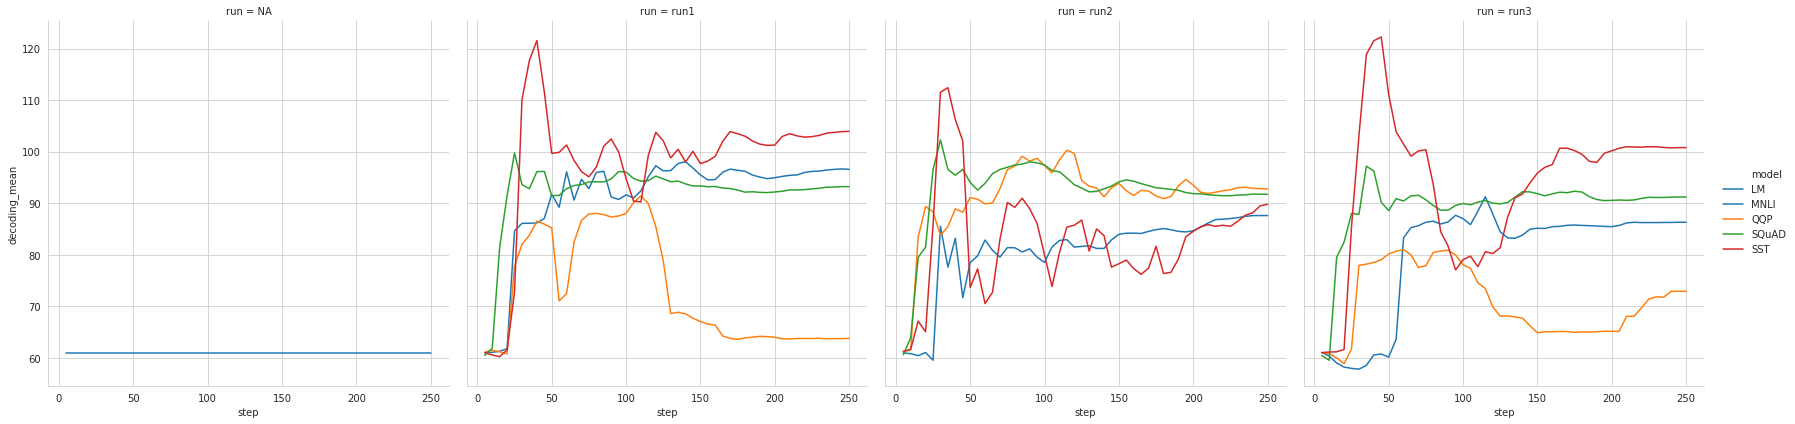

In [475]:
g = sns.FacetGrid(df[df.subject == "M02"], col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mean", "model").add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(1359.78,0.5,'$\\Delta$(MAR$_j$)')

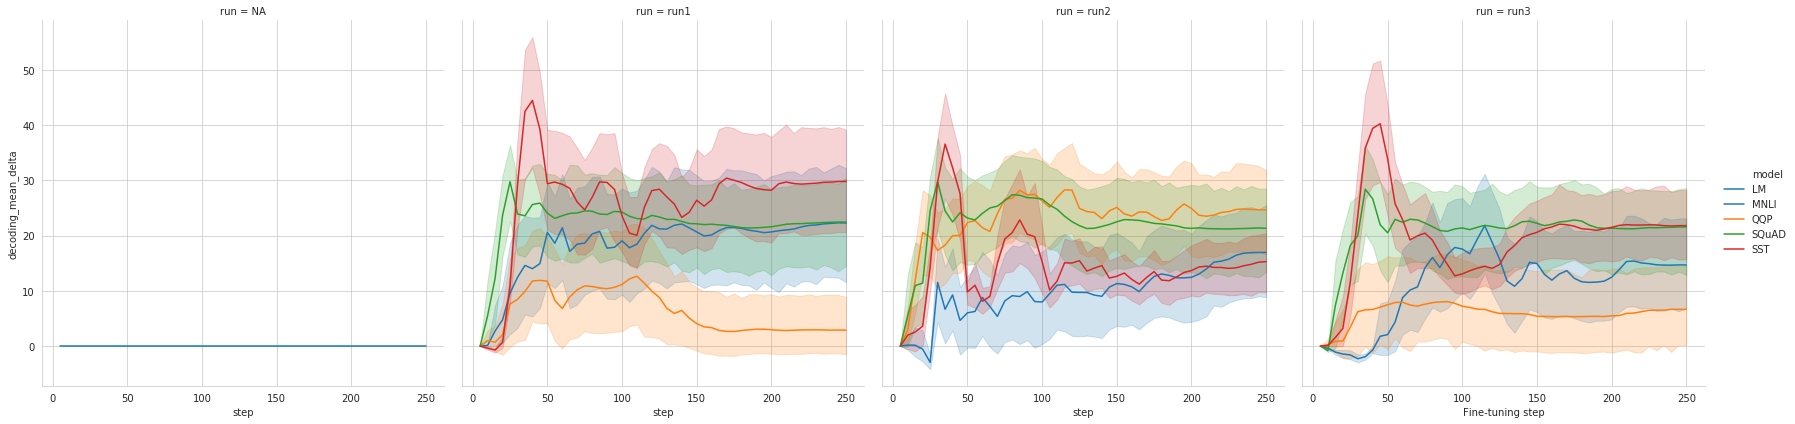

In [476]:
g = sns.FacetGrid(df, col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mean_delta", "model").add_legend()

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


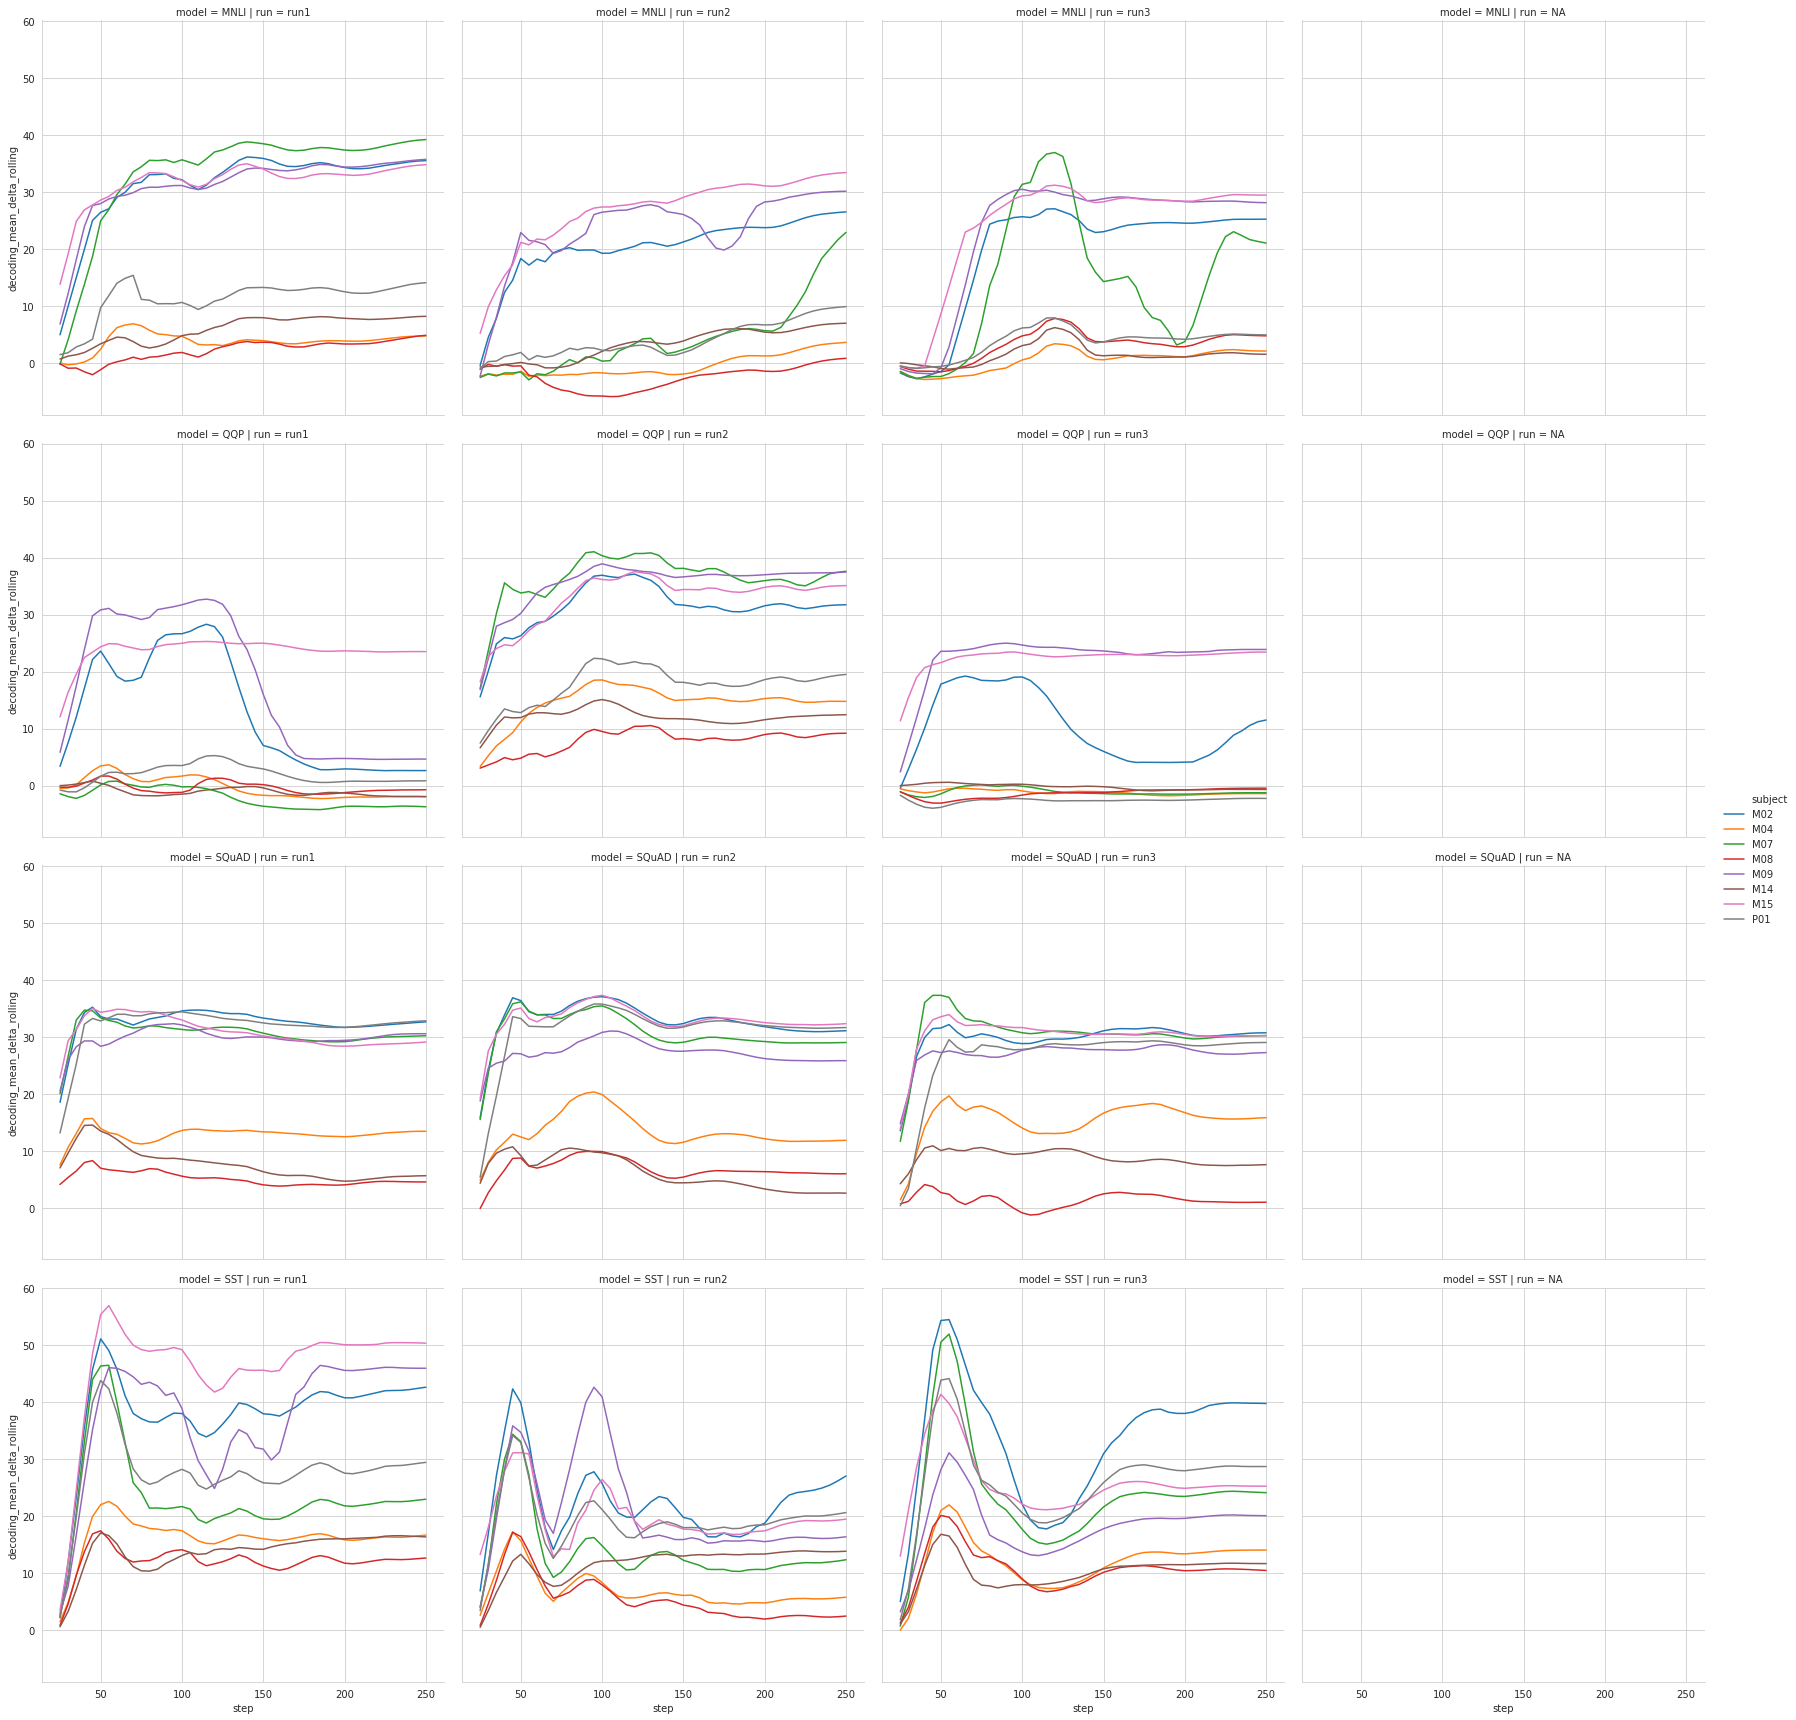

In [477]:
g = sns.FacetGrid(df[df.model != "LM"], row="model", col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mean_delta_rolling", "subject").add_legend()

### Gradient norm analysis

Text(0,0.5,'$\\Delta$(MAR$_j$)')

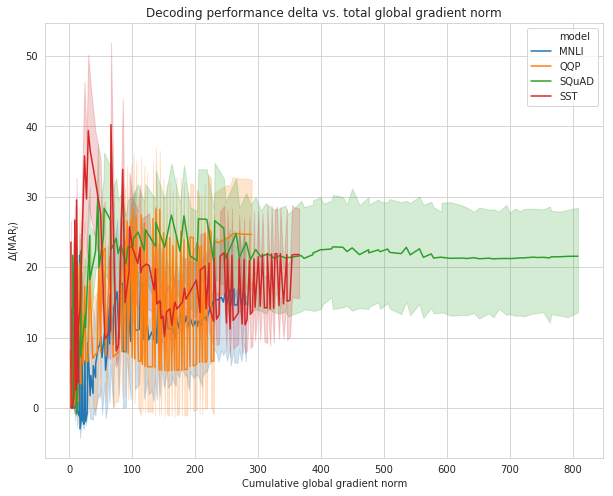

In [478]:
f, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df[df.model != "LM"], y="decoding_mean_delta", x="total_global_norms", hue="model", ax=ax)
ax.set_title("Decoding performance delta vs. total global gradient norm")
ax.set_xlabel("Cumulative global gradient norm")
ax.set_ylabel(MAR_DELTA_LABEL)

Text(23.5124,0.5,'$\\Delta$(MAR$_j$)')

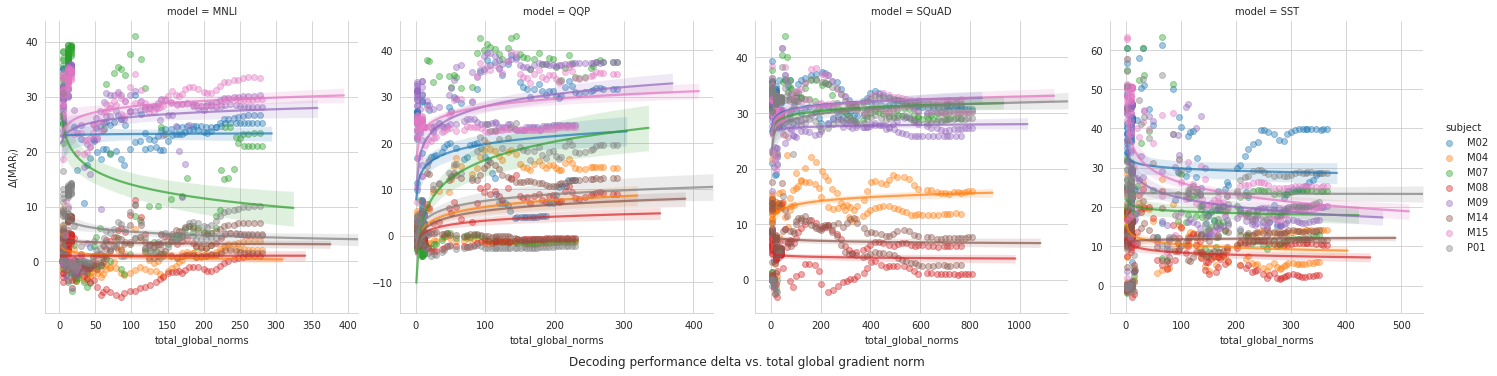

In [479]:
g = sns.lmplot(data=df[df.model != "LM"], y="decoding_mean_delta", x="total_global_norms", col="model", hue="subject",
               logx=True, sharex=False, sharey=False, scatter_kws={"alpha": 0.4}, line_kws={"alpha": 0.7})
plt.suptitle("Decoding performance delta vs. total global gradient norm", y=0)
g.axes.ravel()[0].set_ylabel(MAR_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


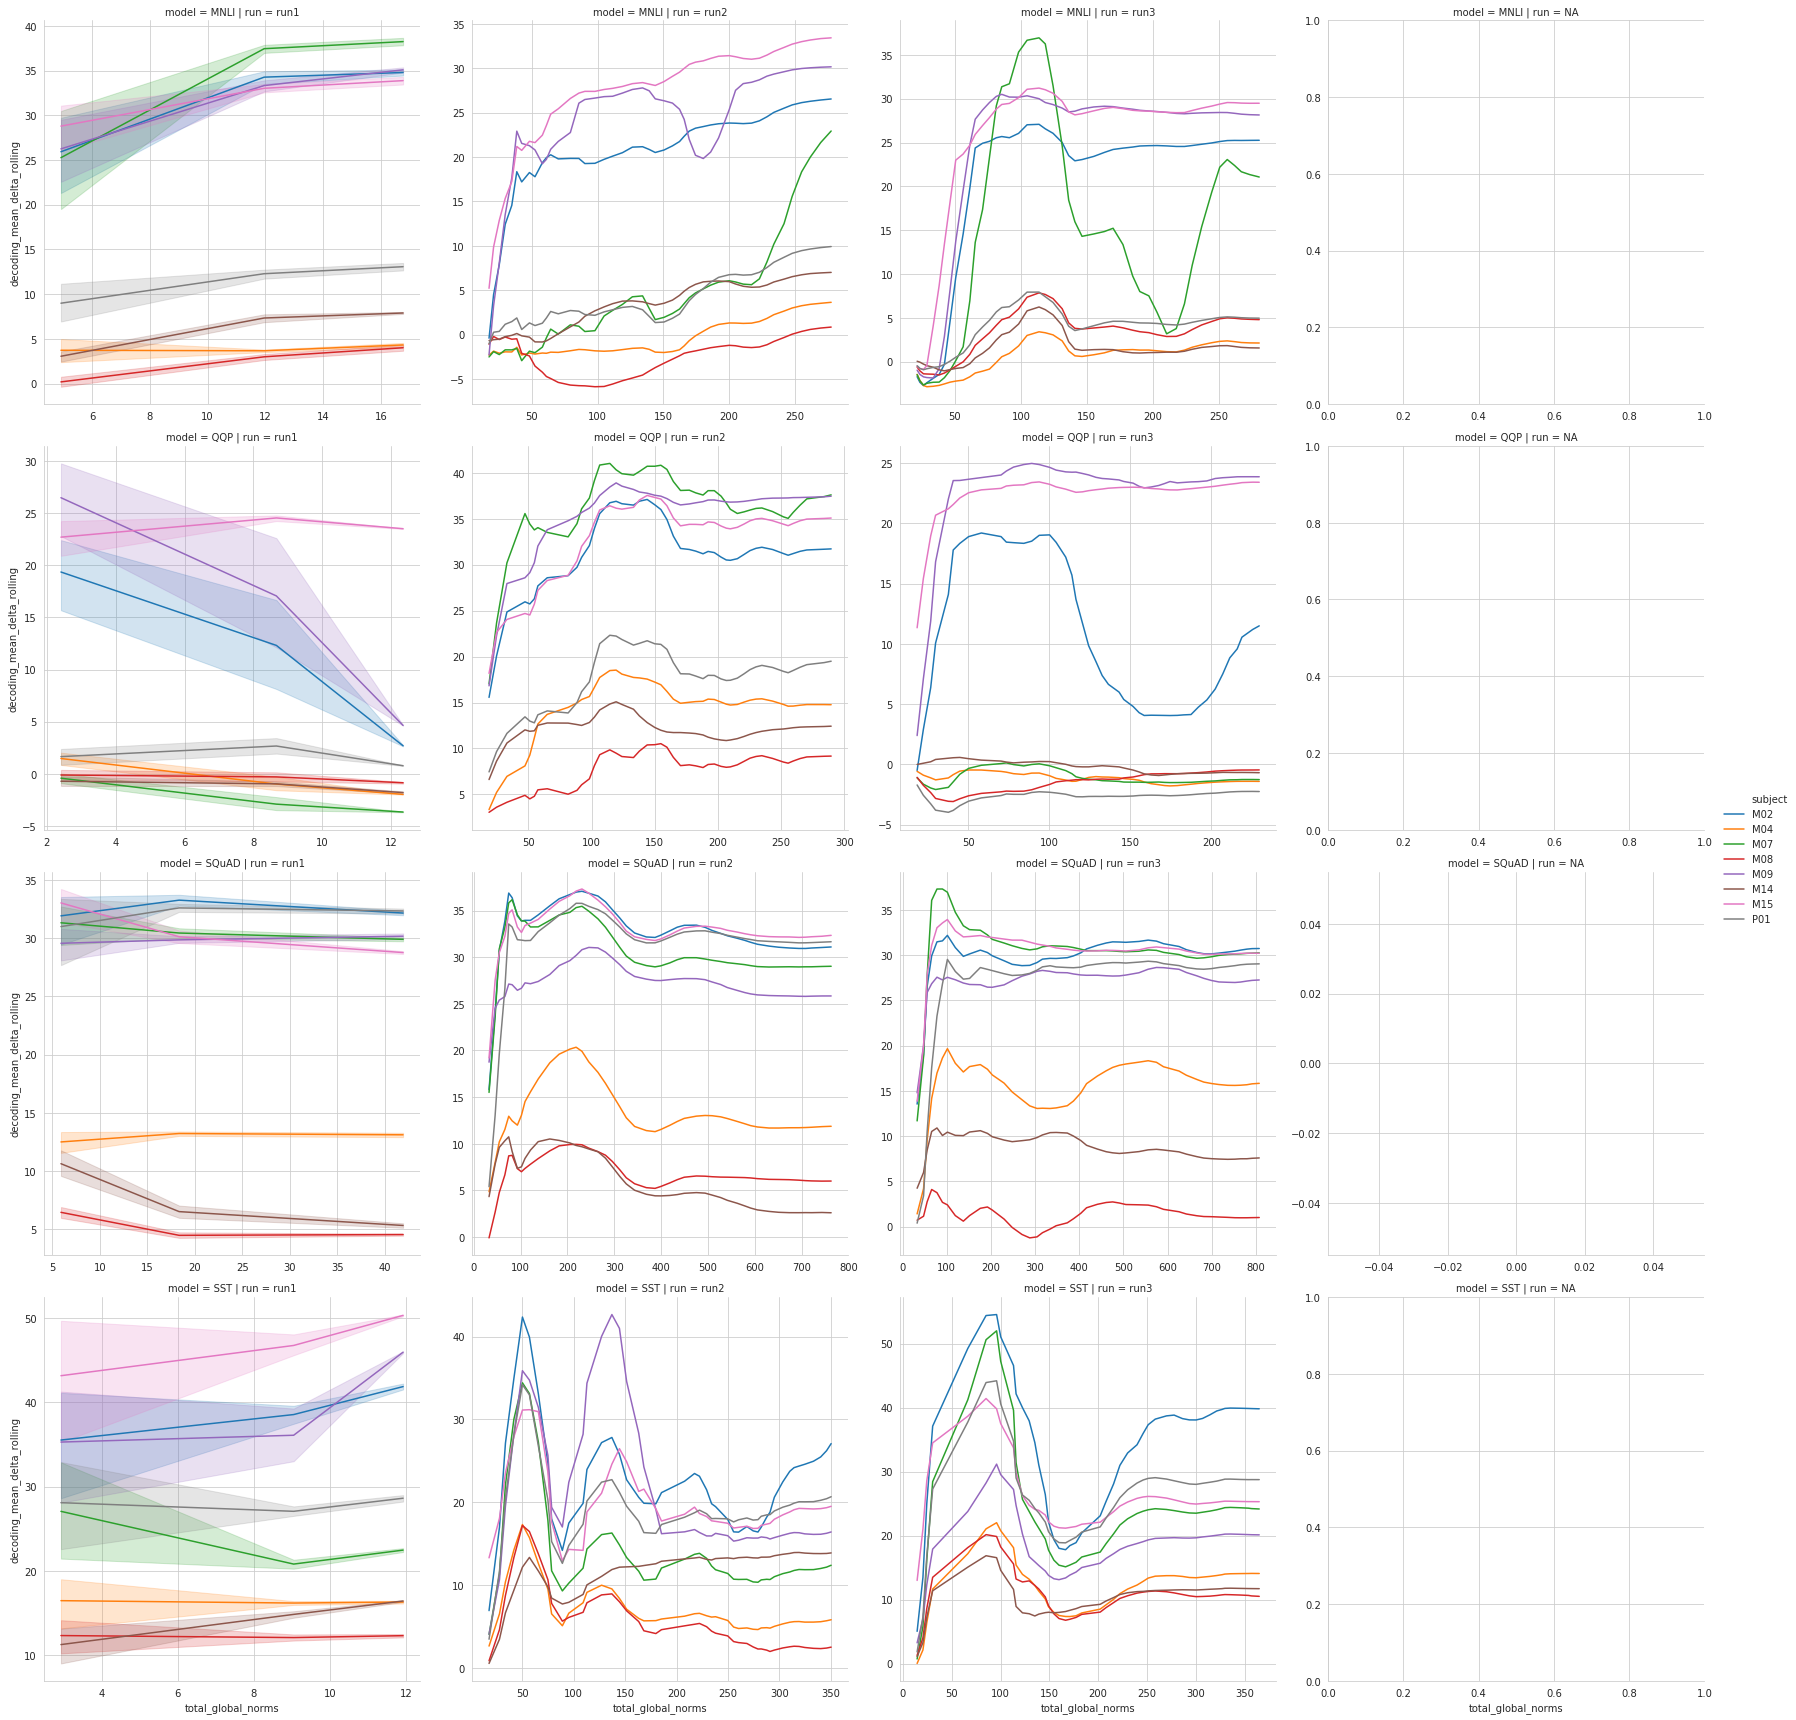

In [480]:
g = sns.FacetGrid(df[df.model != "LM"], row="model", col="run", size=6, sharex=False, sharey=False)
g.map(sns.lineplot, "total_global_norms", "decoding_mean_delta_rolling", "subject").add_legend()

### Eval accuracy analysis

(-10, 60)

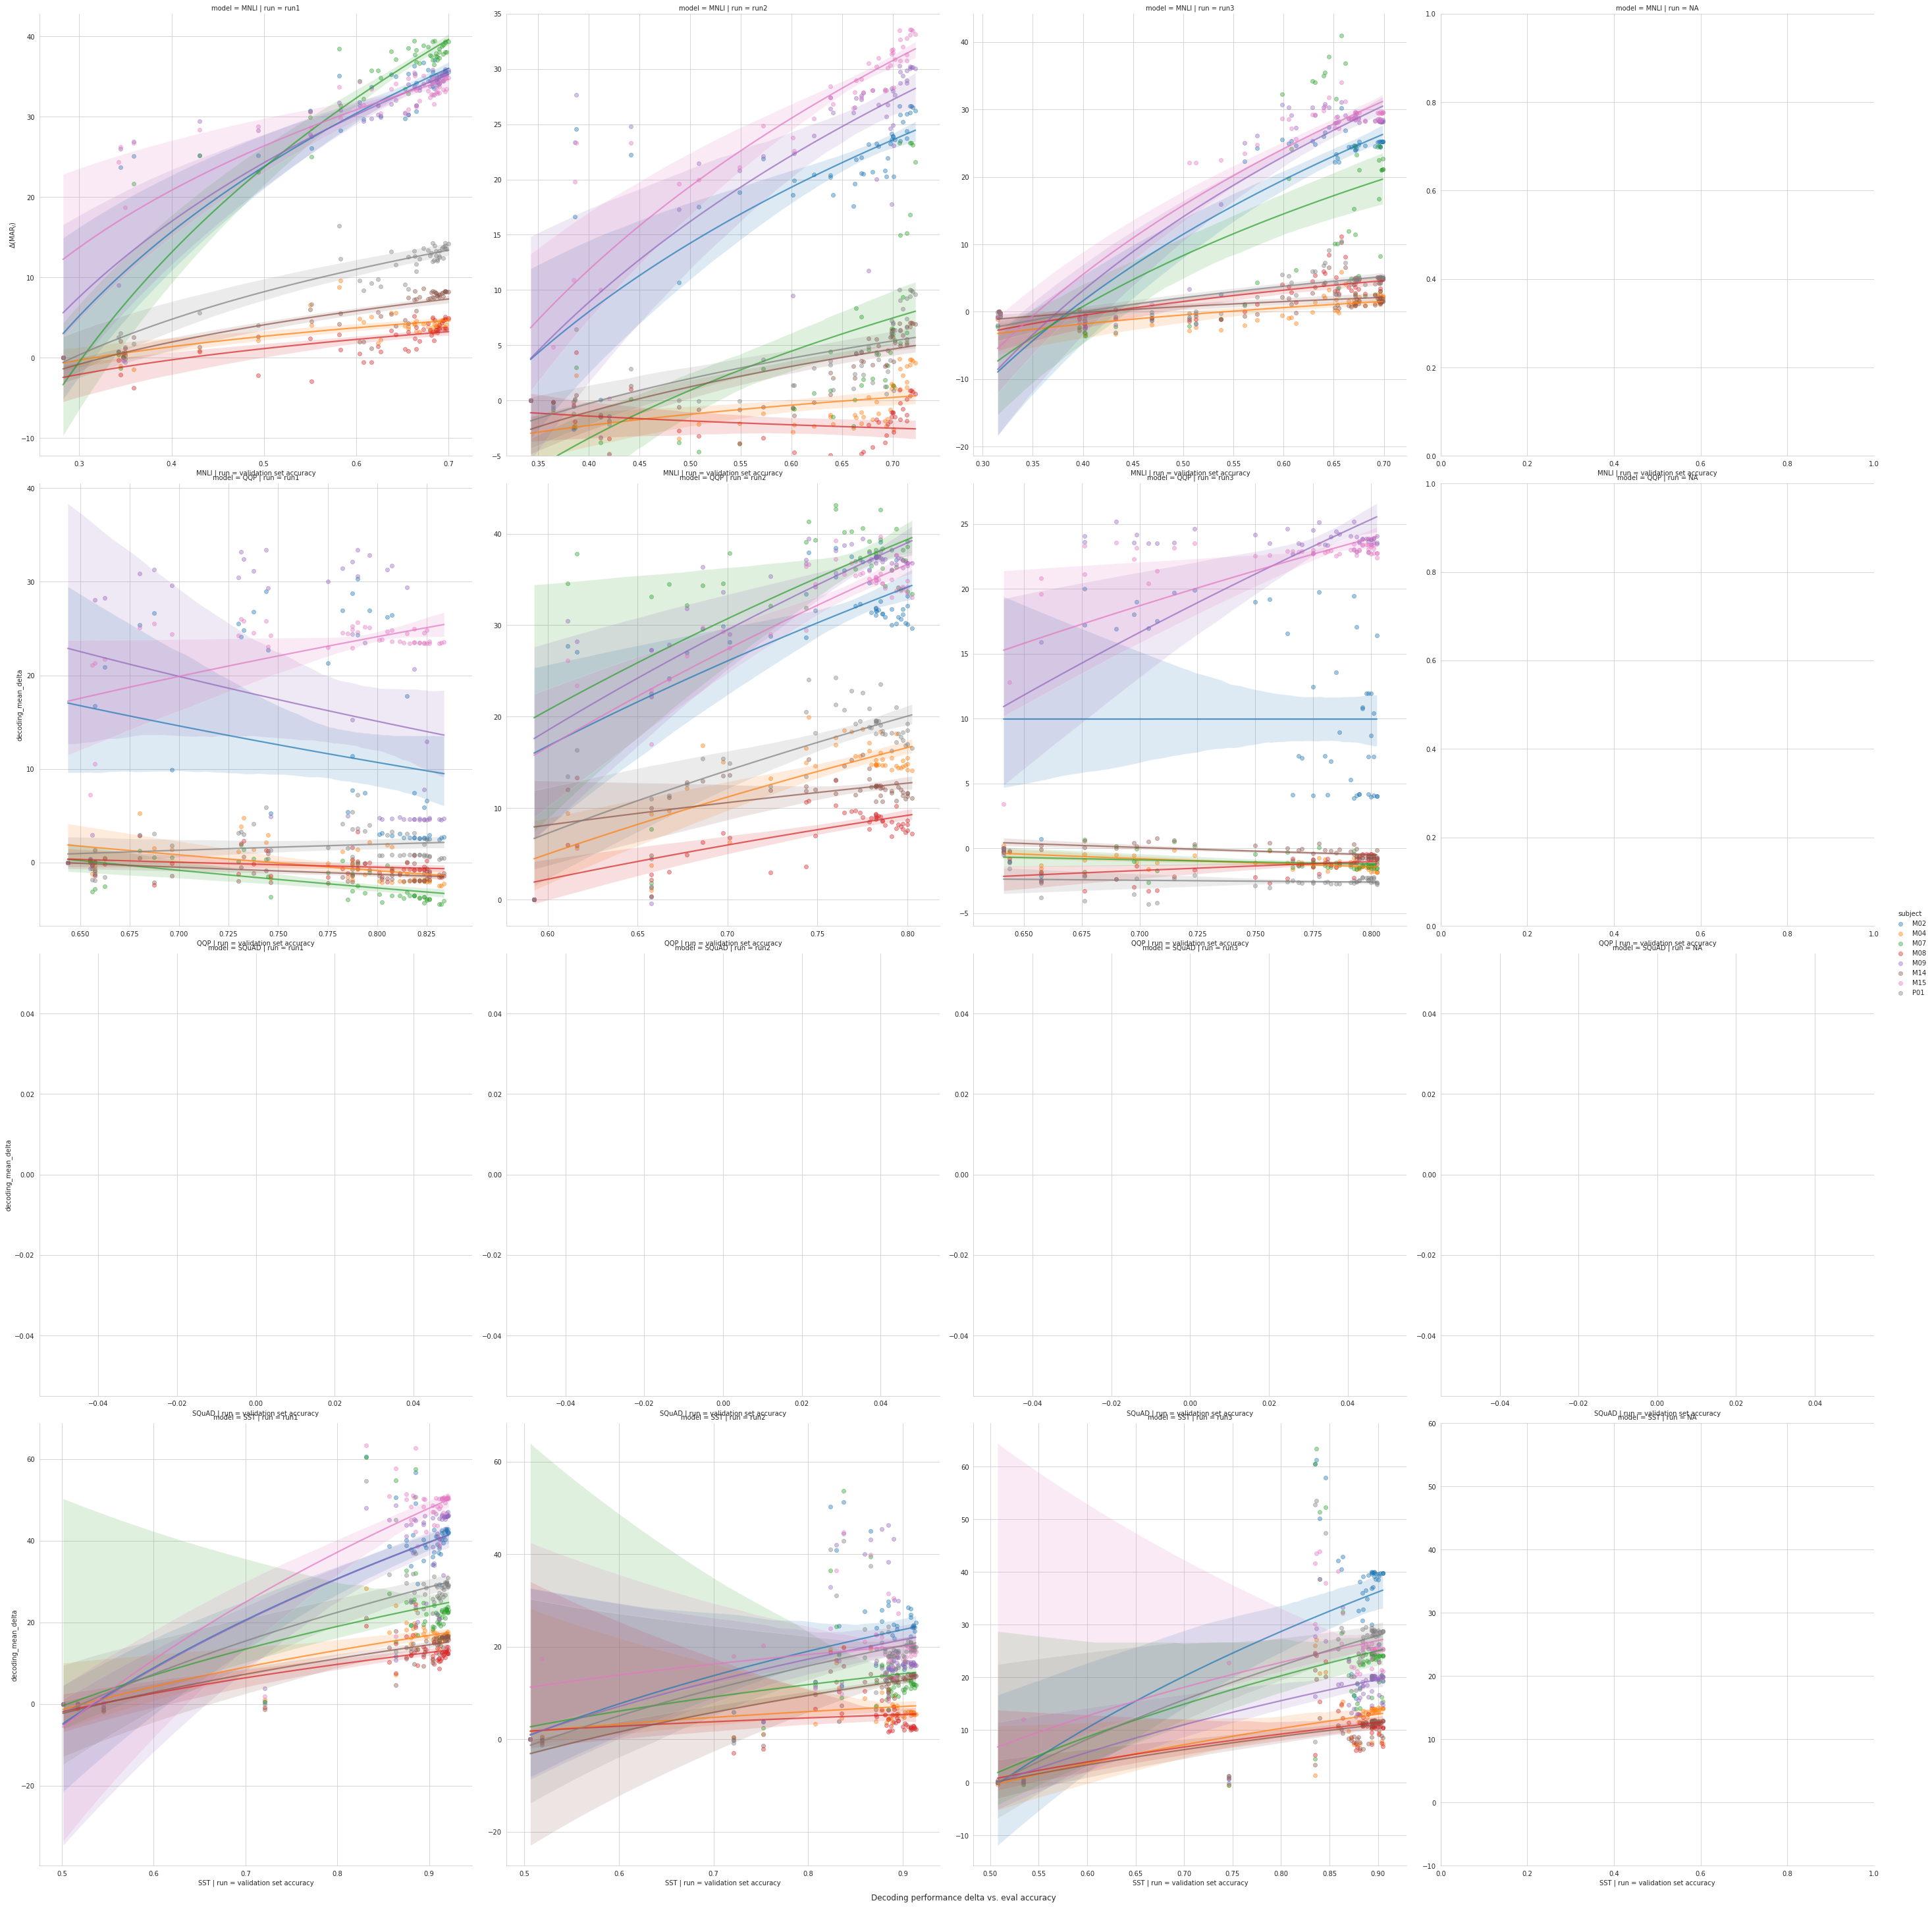

In [481]:
g = sns.lmplot(data=df[df.model != "LM"], y="decoding_mean_delta", x="eval_accuracy", col="run", hue="subject", row="model",
               sharex=False, sharey=False, truncate=True, logx=True, scatter_kws={"alpha": 0.4}, line_kws={"alpha": 0.7}, height=10)
plt.suptitle("Decoding performance delta vs. eval accuracy", y=0.0)

axs = g.axes.ravel()
axs[0].set_ylabel(MAR_DELTA_LABEL)
for ax in axs:
    model_name = re.search(r"model = (.+) ", ax.get_title())
    ax.set_xlabel("%s validation set accuracy" % model_name.group(1))
axs[1].set_ylim((-5, 35)) # QQP
axs[-1].set_ylim((-10, 60)) # SNLI

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


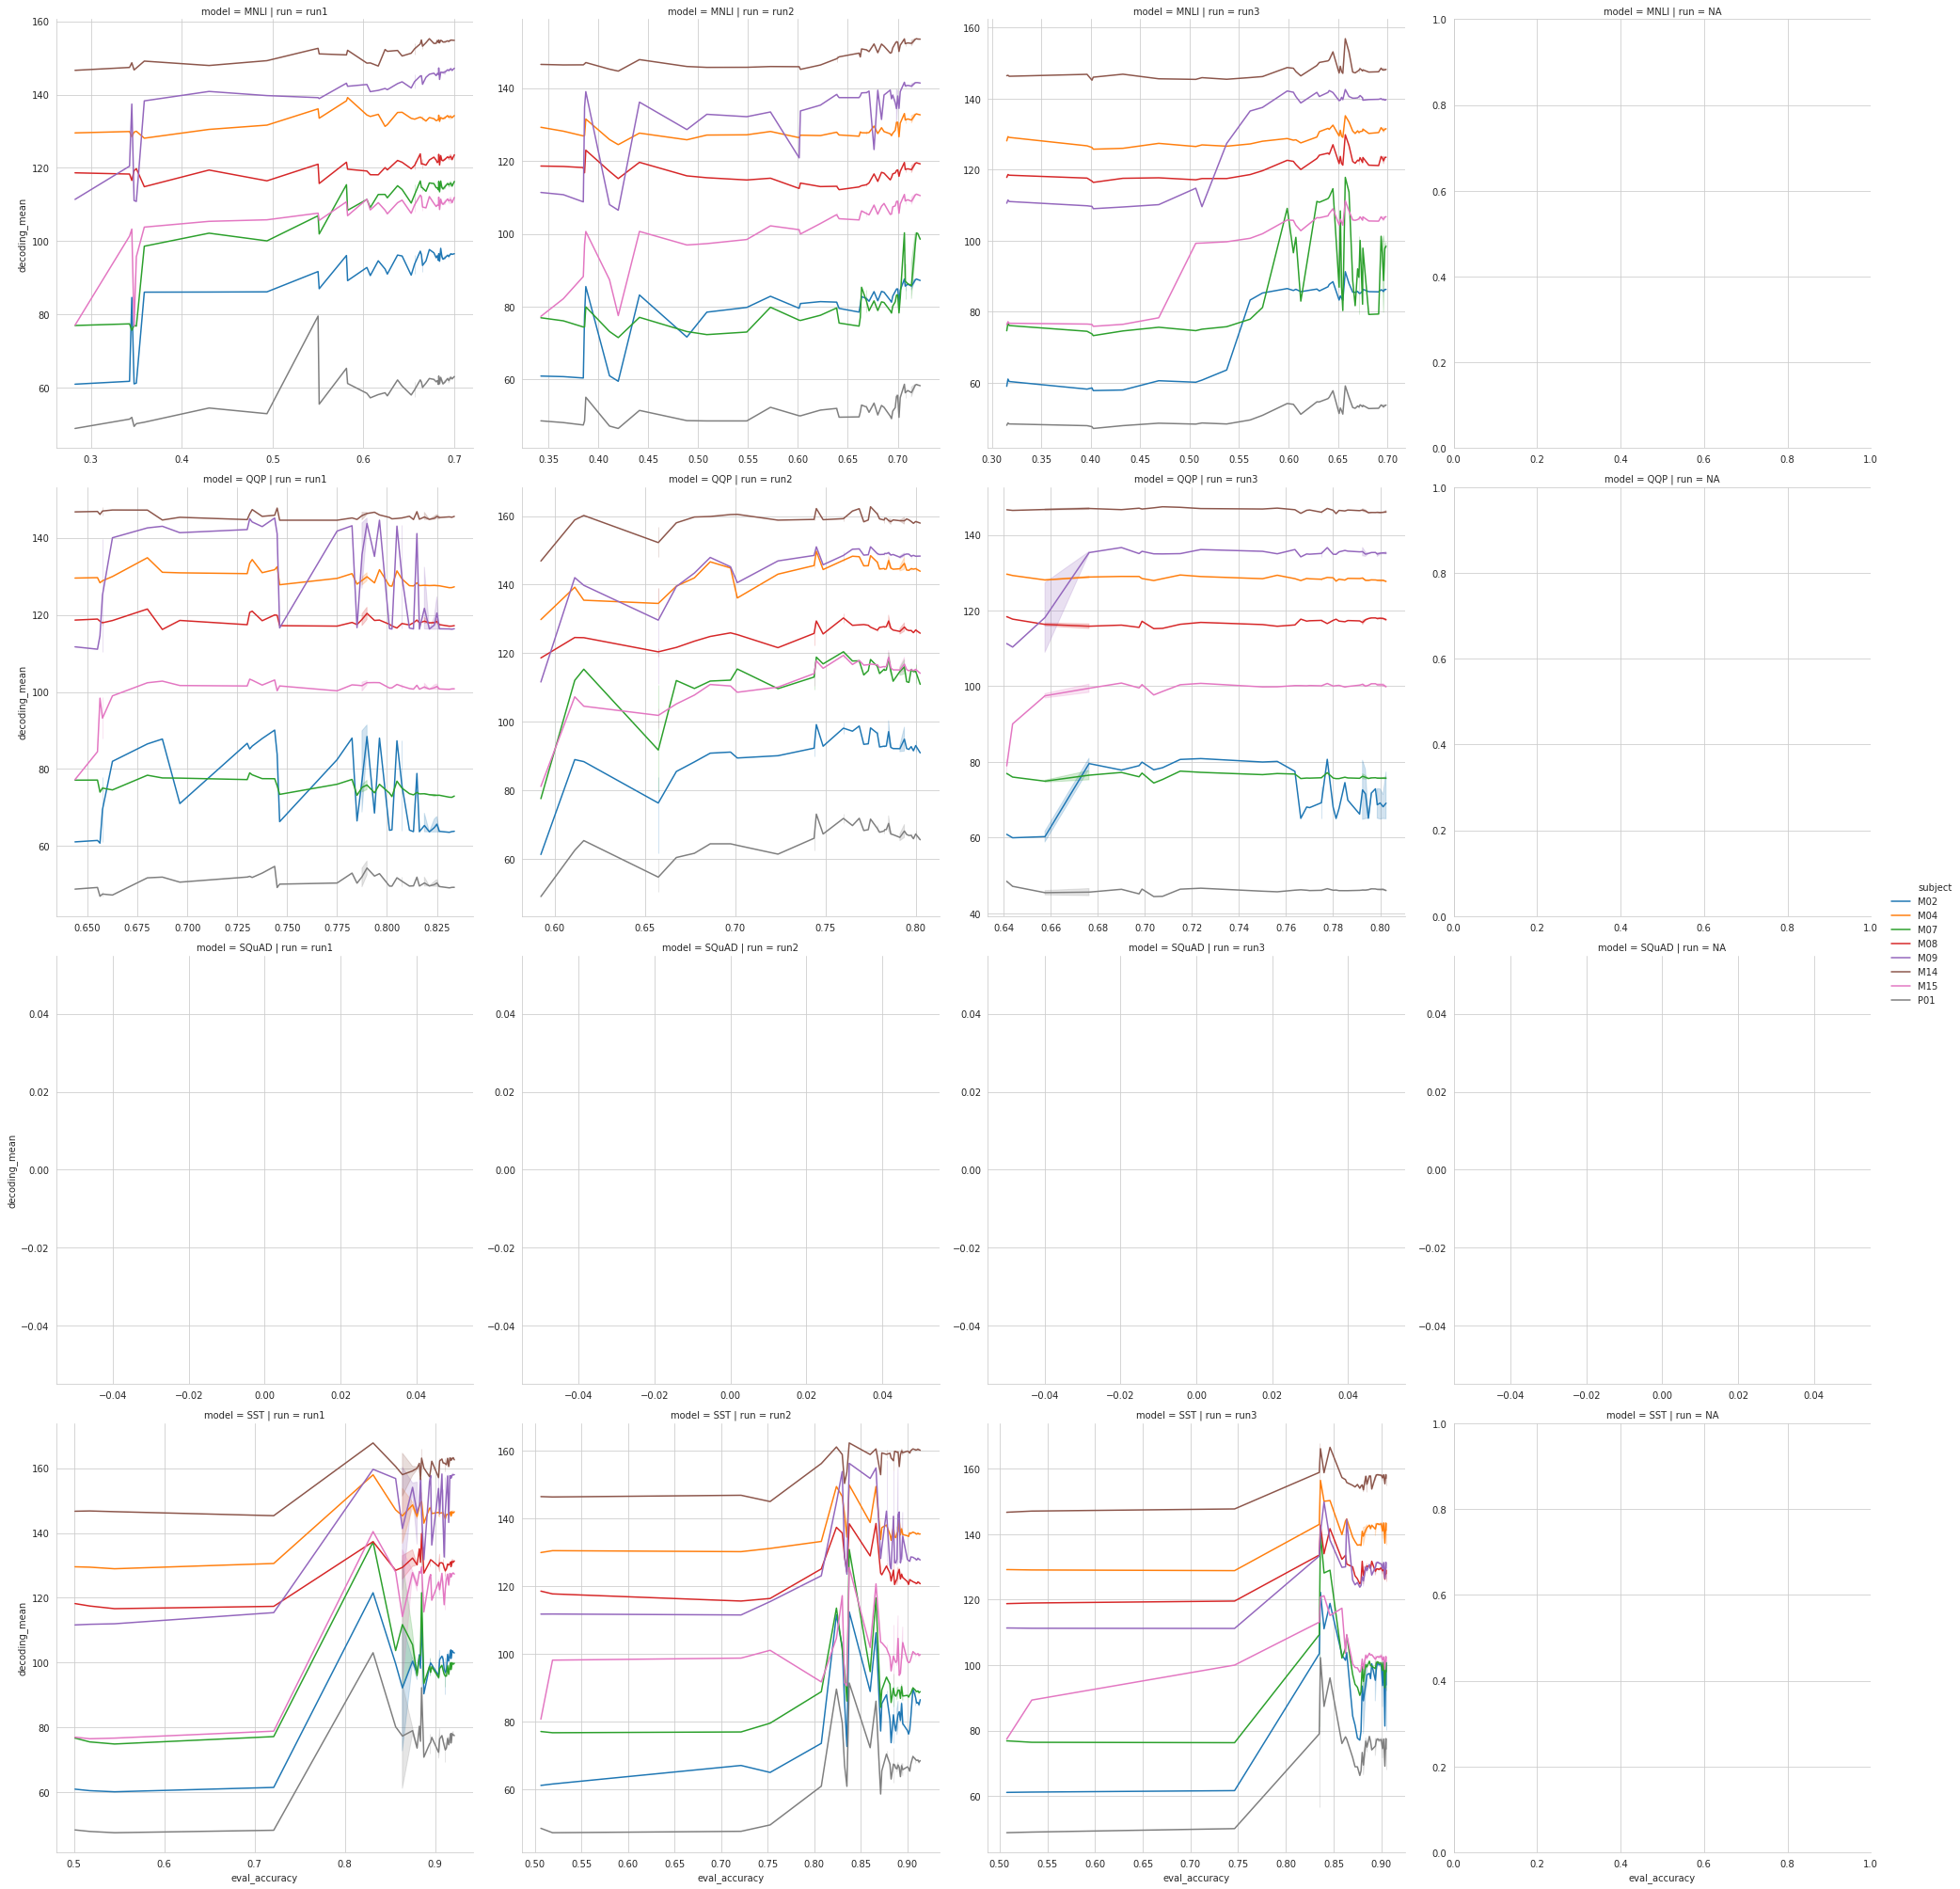

In [482]:
g = sns.FacetGrid(df[df.model != "LM"], row="model", col="run", sharex=False, sharey=False, size=7)
g.map(sns.lineplot, "eval_accuracy", "decoding_mean", "subject").add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


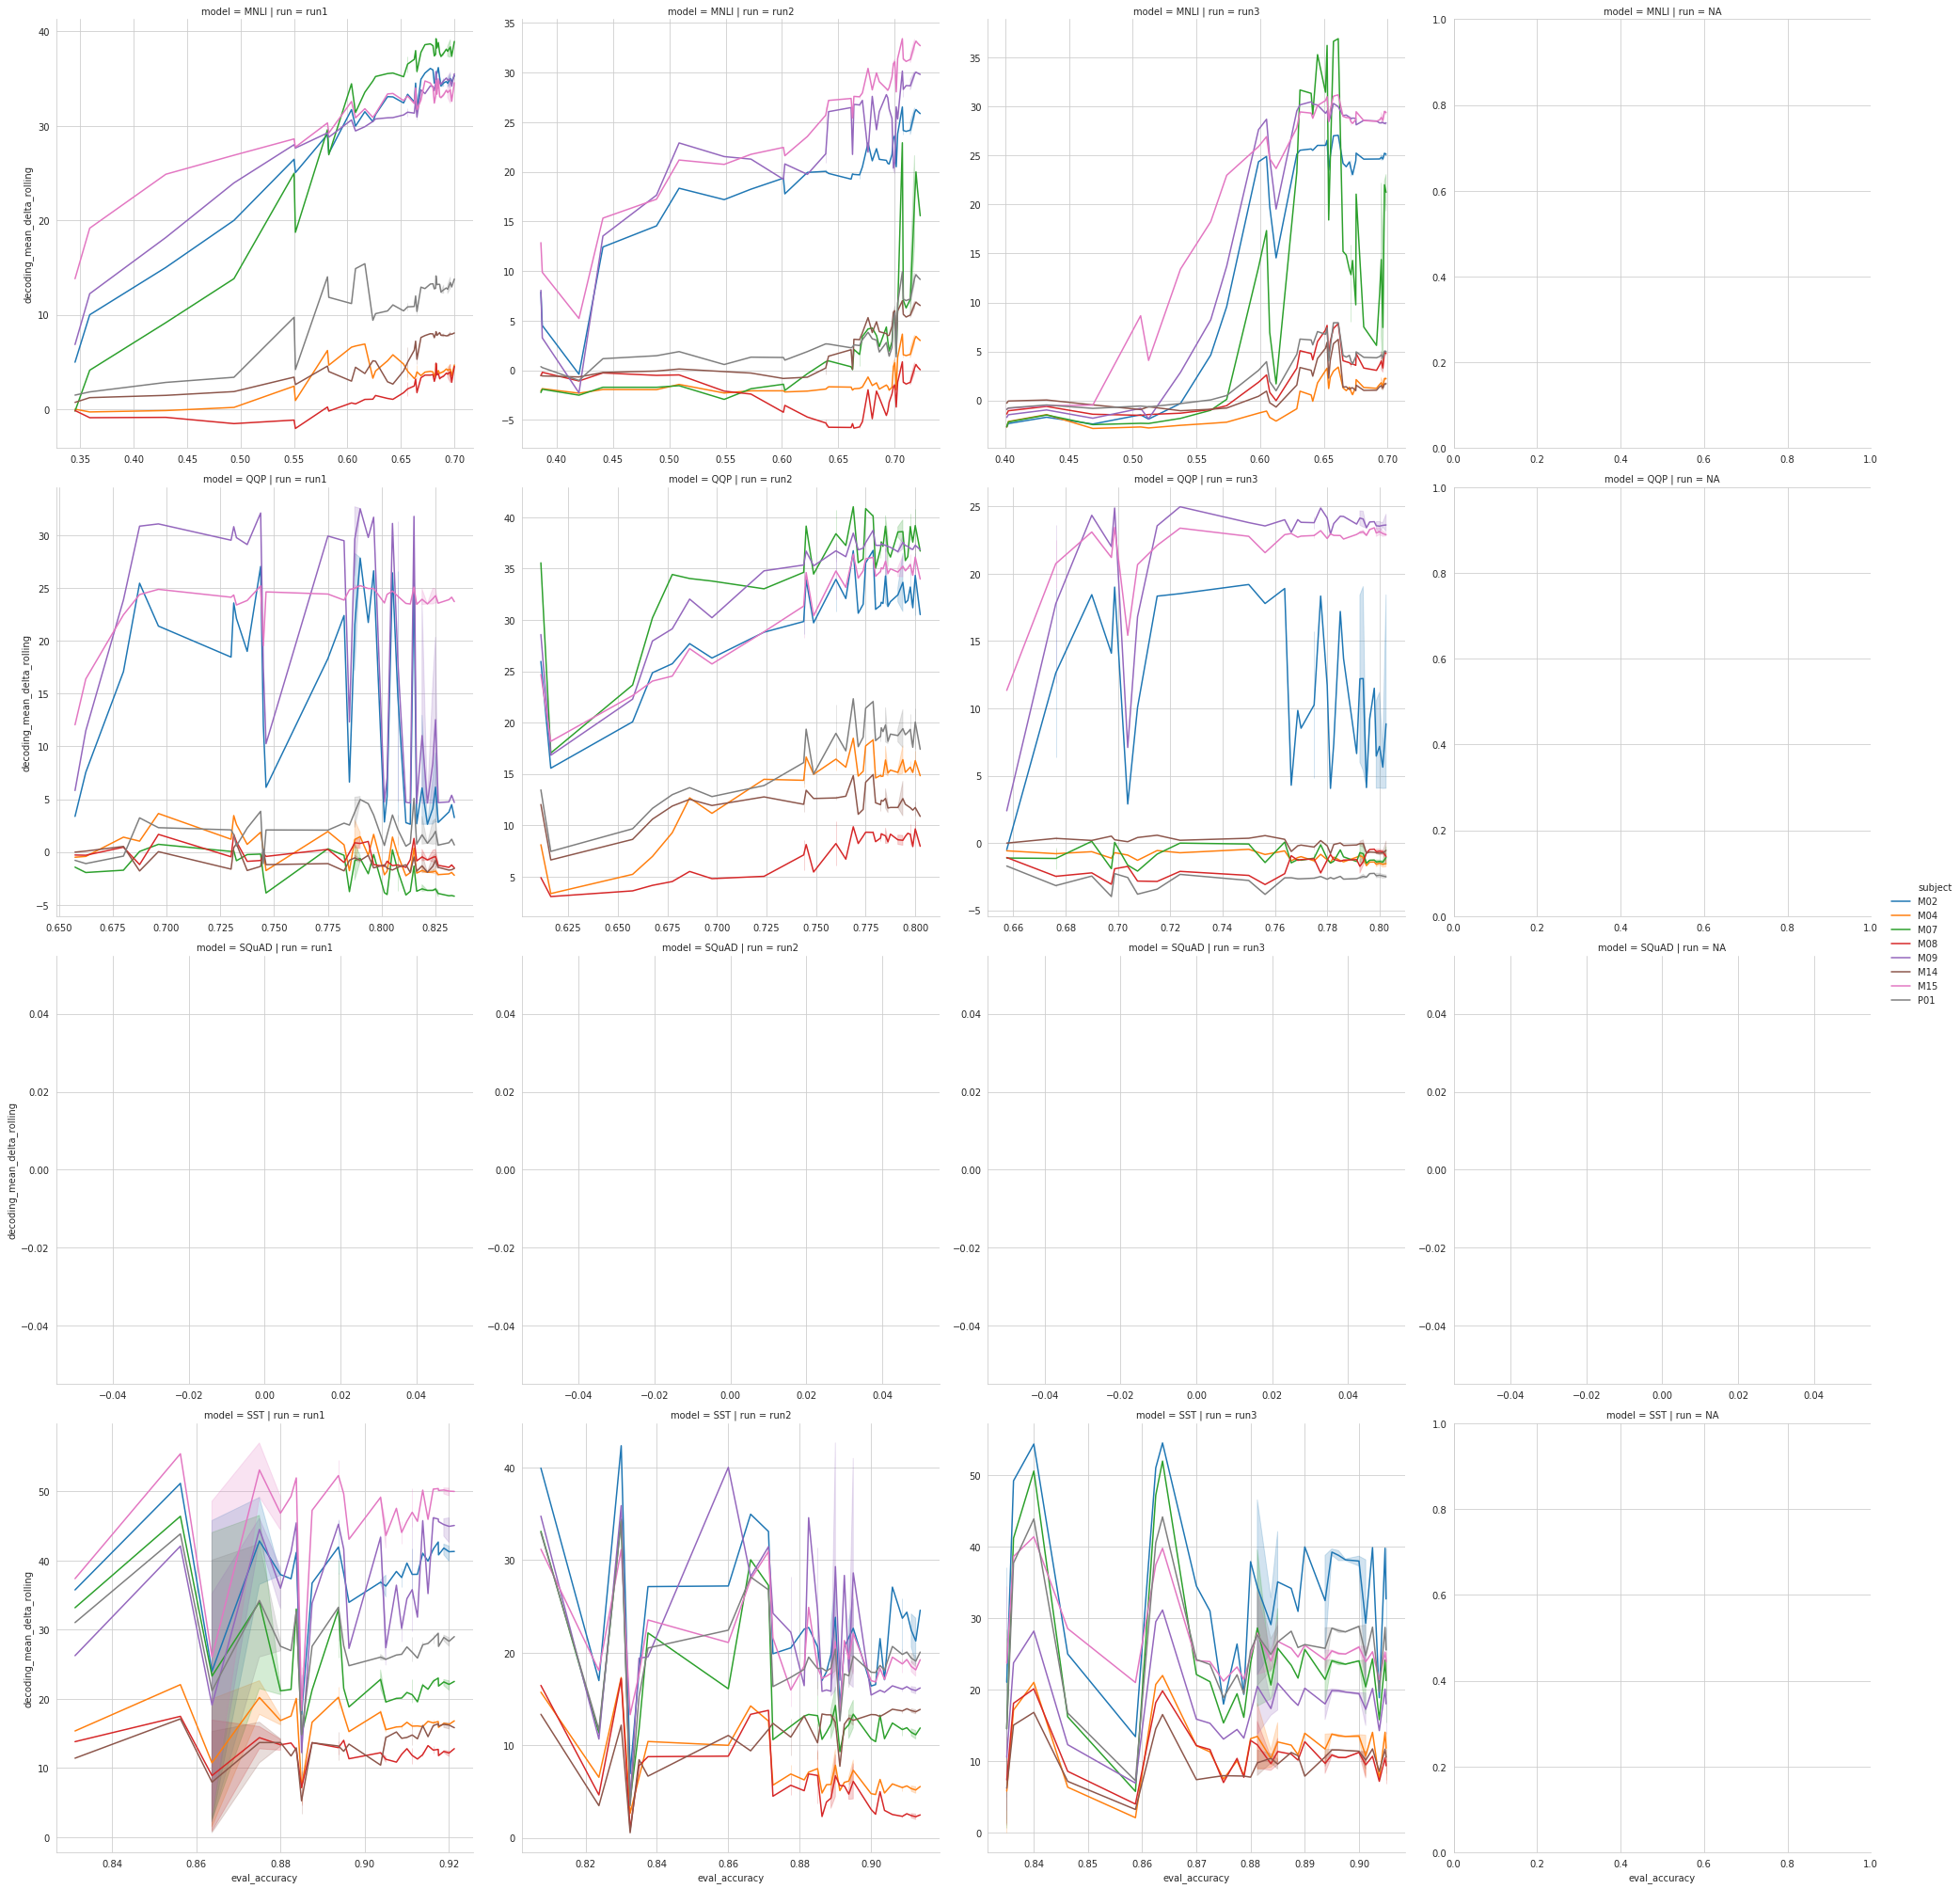

In [483]:
g = sns.FacetGrid(df[df.model != "LM"], row="model", col="run", sharex=False, sharey=False, size=7)
g.map(sns.lineplot, "eval_accuracy", "decoding_mean_delta_rolling", "subject").add_legend()

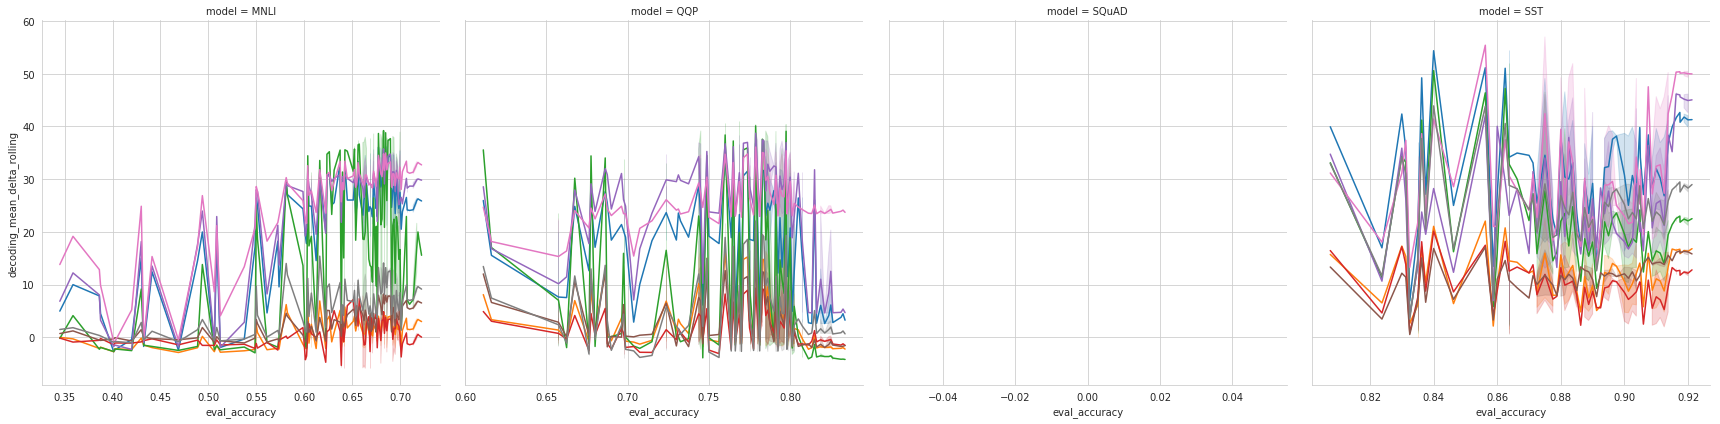

In [484]:
g = sns.FacetGrid(df[df.model != "LM"], col="model", height=6, sharex=False)
g.map(sns.lineplot, "eval_accuracy", "decoding_mean_delta_rolling", "subject")

Text(0.5,1,'subject average decoding mean delta, averaging across runs')

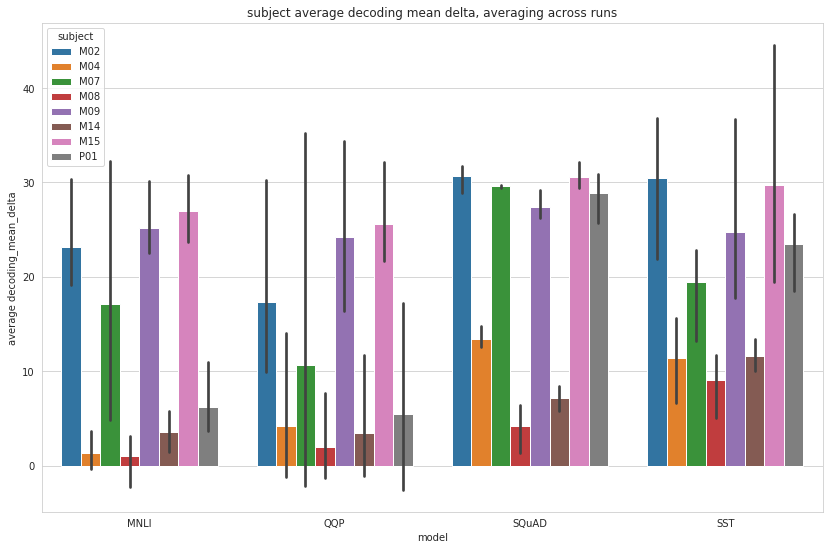

In [485]:
f, ax = plt.subplots(figsize=(14, 9))
dff = df[df.model != "LM"].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mean_delta.mean()).reset_index().melt(id_vars=["model", "run"], value_name="average decoding_mean_delta")
sns.barplot(data=dff, x="model", hue="subject", y="average decoding_mean_delta", ax=ax)
plt.title("subject average decoding mean delta, averaging across runs")

Text(0.5,1,'subject average decoding mean delta, averaging across models and runs')

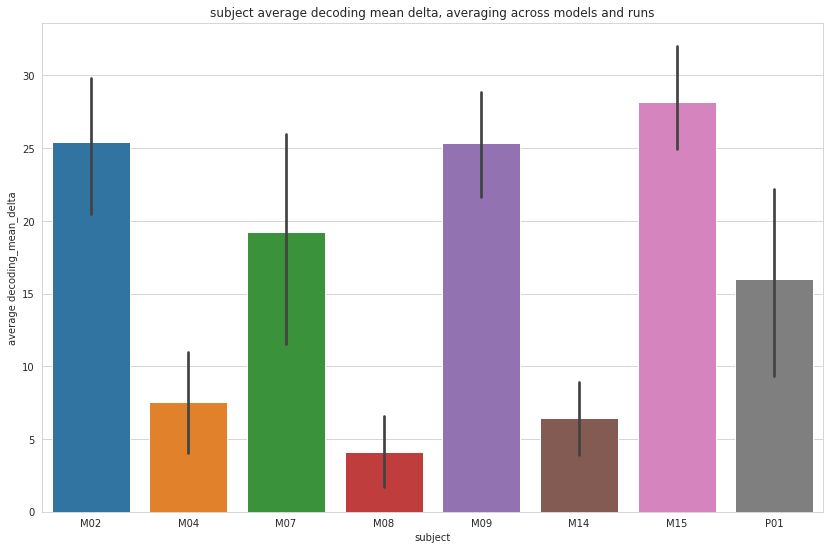

In [487]:
f, ax = plt.subplots(figsize=(14, 9))
dff = df[df.model != "LM"].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mean_delta.mean()).reset_index().melt(id_vars=["model", "run"], value_name="average decoding_mean_delta")
sns.barplot(data=dff, x="subject", y="average decoding_mean_delta", ax=ax)
plt.title("subject average decoding mean delta, averaging across models and runs")

## Regression analyses

In [486]:
from statsmodels.tools import tools

ols_results = []
for (model, subject), model_data in df[df.model != "LM"].groupby(["model", "subject"]):
    X = model_data.eval_accuracy * 100
    # Add bias term.
    #X = np.concatenate([X[:, np.newaxis], np.ones((X.shape[0], 1))], axis=1)
    X = tools.add_constant(X)
    #X -= X.mean()
    #X /= X.std()
    y = model_data.decoding_mean_delta
    #y -= y.mean()
    #y /= y.std()
    
    reg = smf.OLS(y, X).fit()
    ols_results.append((model, subject, reg.params.eval_accuracy, reg.params.const, reg.rsquared))
    
#     print(model, subject)
#     print(reg.summary())

ols_results = pd.DataFrame(ols_results, columns=["model", "subject", "slope", "intercept", "r2"])

MissingDataError: exog contains inf or nans

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
bins = np.linspace(ols_results.slope.min(), ols_results.slope.max(), 10)
for model, ols_results_m in ols_results.groupby("model"):
    sns.distplot(ols_results_m.slope, bins=bins, ax=ax, kde=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
bins = np.linspace(ols_results.intercept.min(), ols_results.intercept.max(), 10)
for model, ols_results_m in ols_results.groupby("model"):
    sns.distplot(ols_results_m.intercept, bins=bins, ax=ax, kde=False)

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))

sns.swarmplot(data=ols_results, x="model", y="slope", ax=ax)
sns.boxplot(data=ols_results, x="model", y="slope", ax=ax, boxprops=dict(alpha=0.3))
ax.set_ylabel("Estimated %s / $\Delta$(Eval accuracy)" % MAR_DELTA_LABEL)

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))

sns.swarmplot(data=ols_results, x="model", y="intercept", ax=ax)
sns.boxplot(data=ols_results, x="model", y="intercept", ax=ax, boxprops=dict(alpha=0.3))
ax.set_ylabel("Estimated intercept")

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="subject", hue="model", y="slope", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="model", hue="subject", y="slope", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="subject", hue="model", y="intercept", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="model", hue="subject", y="intercept", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=ols_results, x="model", y="r2", hue="subject", ax=ax)

In [ ]:
ols_results.sort_values("r2")

In [ ]:
%load_ext rpy2.ipython
%R require(brms)

In [ ]:
regression_data = df[df.model.notnull()]
regression_data.to_csv("regression_data.csv")

In [ ]:
%R summary(brm("decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject) + (1 + eval_accuracy | model)",
               data=read.csv("regression_data.csv"), iter=2000, chains=10, cores=10))

R results from the above regression, run from the command line (19 Feb 2019 12:46):

```
> ranef(mylm)
$model
, , Intercept

      Estimate Est.Error      Q2.5     Q97.5
MNLI  16.75141  22.41457 -28.67321 62.633228
QQP   33.96295  22.71539 -10.84474 80.443706
SST  -51.11941  22.68847 -97.77289 -5.678948

, , eval_accuracy

      Estimate Est.Error        Q2.5      Q97.5
MNLI -17.34233  32.23074  -82.818005  46.545622
QQP  -60.07987  32.50367 -126.434392   4.141062
SST   73.80767  32.45963    8.068293 139.260863


$subject
, , Intercept

     Estimate Est.Error        Q2.5      Q97.5
M02 -52.60407  19.08174  -89.177671 -14.155082
M04  60.89416  19.02727   23.720952  99.224670
M07 -28.94065  19.08834  -66.611534   8.715856
M08  35.14006  19.06391   -1.525497  73.038507
M09  57.39263  19.05641   20.876435  95.498854
M14  46.39296  19.10505    9.697139  84.118757
M15 -31.00785  19.16315  -68.451523   7.205317
P01 -92.88771  19.02479 -129.951903 -54.686867

, , eval_accuracy

     Estimate Est.Error        Q2.5     Q97.5
M02  27.99022  13.44256   0.9550976  53.68828
M04 -45.23083  13.34530 -72.4967273 -19.22681
M07  16.20350  13.40520 -10.1863048  43.10497
M08 -29.82243  13.34506 -56.5382954  -3.72094
M09 -41.79735  13.42123 -68.6505984 -15.72548
M14 -10.06899  13.44356 -37.0225402  15.87794
M15  36.78132  13.59707   9.4990463  63.47709
P01  48.49375  13.40848  21.8274816  74.81344

> print(summary(mylm))
 Family: gaussian
  Links: mu = identity; sigma = identity
Formula: decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject) + (1 + eval_accuracy | model)
   Data: read.csv("regression_data.csv") (Number of observations: 4480)
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects:
~model (Number of levels: 3)
                             Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                   40.63     15.39    20.68    79.10       2248
sd(eval_accuracy)               56.98     18.27    31.11   101.90       2454
cor(Intercept,eval_accuracy)    -0.70      0.29    -0.99     0.07       1846
                             Rhat
sd(Intercept)                1.00
sd(eval_accuracy)            1.00
cor(Intercept,eval_accuracy) 1.00

~subject (Number of levels: 8)
                             Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                   54.54     12.39    35.53    83.32       1440
sd(eval_accuracy)               35.29      8.42    22.94    55.87       1577
cor(Intercept,eval_accuracy)    -0.85      0.12    -0.97    -0.54       2211
                             Rhat
sd(Intercept)                1.00
sd(eval_accuracy)            1.00
cor(Intercept,eval_accuracy) 1.00

Population-Level Effects:
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept        68.89     29.31    10.32   125.17       1560 1.00
eval_accuracy    56.19     35.37   -11.61   128.69       1389 1.00

Family Specific Parameters:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     8.14      0.09     7.97     8.31       4974 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample
is a crude measure of effective sample size, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).
Warning message:
There were 322 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
```

In [ ]:
%R mylm <- brm("decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)", data=read.csv("regression_data.csv"), iter=2000, control=list(max_treedepth=15))

R results from the above regression, run on the command line (18 Feb 2019 17:21):

```
> ranef(mylm)
$model
, , Intercept

        Estimate Est.Error       Q2.5     Q97.5
MNLI  -0.8675875  15.13298 -32.433042 30.235024
QQP  -23.6366560  15.13622 -55.387579  7.397331
SST   22.1441808  15.14019  -9.242302 52.952531

, , logeval_accuracy

      Estimate Est.Error        Q2.5     Q97.5
MNLI -15.19145  31.06674  -78.348188  49.57885
QQP  -41.12545  31.15355 -104.168428  22.72867
SST   53.46094  31.11354   -9.910603 119.74002


$subject
, , Intercept

      Estimate Est.Error       Q2.5      Q97.5
M02 -26.421842  10.45573 -47.257870  -6.309088
M04  17.524082  10.42141  -3.029840  37.743235
M07 -14.033033  10.43504 -34.808899   6.218818
M08   6.260752  10.44637 -14.783196  26.722411
M09  17.670682  10.42522  -3.079233  38.154109
M14  36.111953  10.43270  15.420709  56.384843
M15   3.572897  10.44743 -17.174979  23.966986
P01 -47.612600  10.44023 -68.451741 -27.314897

, , logeval_accuracy

      Estimate Est.Error        Q2.5      Q97.5
M02  17.512027  9.169878  -0.3198393 36.1756958
M04 -26.612520  9.254896 -45.4697303 -8.2981598
M07   9.935814  9.191353  -8.2876422 28.3847439
M08 -18.202115  9.114860 -36.2836541 -0.4659212
M09 -22.337849  9.196614 -40.7158639 -4.4865540
M14  -7.280584  9.148384 -25.3590395 10.4895344
M15  23.141154  9.242823   5.1133918 42.1331905
P01  27.737438  9.122779  10.2663030 46.6575899

> print(summary(mylm)
+ )
 Family: gaussian
  Links: mu = identity; sigma = identity
Formula: decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)
   Data: read.csv("regression_data.csv") (Number of observations: 4480)
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects:
~model (Number of levels: 3)
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                      27.24     13.11    11.79    61.57       2603
sd(logeval_accuracy)               51.11     21.96    24.58   107.47       2636
cor(Intercept,logeval_accuracy)     0.55      0.37    -0.34     0.97       3216
                                Rhat
sd(Intercept)                   1.00
sd(logeval_accuracy)            1.00
cor(Intercept,logeval_accuracy) 1.00

~subject (Number of levels: 8)
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                      30.08      8.40    18.34    51.22       1603
sd(logeval_accuracy)               24.68      7.35    14.47    42.45       1888
cor(Intercept,logeval_accuracy)    -0.56      0.25    -0.89     0.07       2196
                                Rhat
sd(Intercept)                   1.00
sd(logeval_accuracy)            1.00
cor(Intercept,logeval_accuracy) 1.00

Population-Level Effects:
                 Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept          123.17     17.75    87.90   159.74       1914 1.00
logeval_accuracy    37.93     32.30   -29.31   101.19       2436 1.00

Family Specific Parameters:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     8.31      0.09     8.14     8.49       6210 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample
is a crude measure of effective sample size, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).
Warning message:
There were 13 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
```

In [ ]:
%R -o ran ran=ranef(mylm)

In [ ]:
%R print(summary(mylm))

## Transfer checks

In [ ]:
transfer_results = {}
for model in bert_models:
    # Get original fine-tune accuracy
    # TODO update "finetune" to `finetune_desc` once we have transfer data for the new limited finetune models
    results_path = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model)) / "eval_results.txt"
    if results_path.exists():
        with results_path.open("r") as results_f:
            acc, = re.findall(r"^eval_accuracy\s*=\s*([\d.-]+)$", results_f.read(), re.M)
            acc = float(acc)
            transfer_results[model, model] = acc
            
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / ("eval_transfer-%s" % finetune_desc) / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]

plt.subplots(figsize=(20, 10))
transfer_results = pd.Series(transfer_results)
transfer_results.index.rename(["m1", "m2"], inplace=True)
transfer_results = transfer_results.sort_index().reset_index()
print(transfer_results)

ax = sns.barplot(data=transfer_results, hue="m2", x="m1", y=0)
i = 0
for bar in sorted(ax.patches, key=lambda bar: bar.get_x()):
    row = transfer_results.iloc[i]
    if not np.isnan(bar.get_height()):
        if row.m1 == row.m2:
            bar.set_hatch("/")
            
        i += 1

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(data=pd.pivot_table(transfer_results, index="m1", columns="m2", values=0), annot=True)